In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import calendar
from datetime import datetime, timedelta

In [3]:
#Input data
time_from = '2020-01-01'
time_to = '2021-12-31'

In [4]:
#api semd win data till 22:00 time to
time_to_datetime_type = datetime.strptime(time_to, '%Y-%m-%d').date()
time_to_for_api = time_to_datetime_type + timedelta(days=1)
time_from_for_api = time_from

#Load wind data from ameteo api
fields = ['date', 'time', 'wind']
api_data = f'http://mech.fis.agh.edu.pl/meteo/rest/csv/winds/s000/{time_from_for_api}/{time_to_for_api}'
my_data = pd.read_csv(api_data, sep=" |,", names=fields, header=None, engine='python')

my_data

,date,time,wind
0,2019-12-31,22:00:35,2.7
1,2019-12-31,22:01:23,2.0
2,2019-12-31,22:02:11,3.7
3,2019-12-31,22:02:59,2.7
4,2019-12-31,22:03:47,3.4
...,...,...,...
1287483,2022-01-01,21:56:11,2.0
1287484,2022-01-01,21:56:59,1.0
1287485,2022-01-01,21:57:47,1.0
1287486,2022-01-01,21:58:35,1.4


In [6]:
#Create wind turbine data in JSON file
ID_product = "wind_turbine_001"
comapny_name = "Wibine"
turbine_high = 50
turbine_blade_high = 8
x_speed_axis = [0, 3, 4, 5, 8, 10, 12, 14, 14, 18]
y_power_axis = [0, 0, 2, 4, 12, 18, 21, 19, 0, 0]
turibne_data = {"x_speed_axis" : x_speed_axis,
                "y_power_axis" : y_power_axis}

turibne_data_file = {
    "ID_product" : ID_product,
    "comapny_name" : comapny_name,
    "turbine_high" : turbine_high,
    "turibne_data" : turibne_data,
    
}

with open("turbines_data.json", "a") as turbines_data:
    json.dump(turibne_data_file, turbines_data)


In [5]:
# If data json exist already
ID_product = "wind_turbine_001"

# Opening JSON file
ID_product = "wind_turbine_001"
with open('turbines_data.json', 'r') as turbines_data_from_file:
 
    # Reading from json file
    turbines_data_json = json.load(turbines_data_from_file)
    

In [6]:
#create a polynomial with x_speed_axis and y_power_axis turbine data
x_turbine_speed_axis = turbines_data_json['turibne_data']['x_speed_axis']
y_turbine_spower_axis = turbines_data_json['turibne_data']['y_power_axis']
degree_polynomial = 8

turbine_polynomial = np.polyfit(x_turbine_speed_axis, y_turbine_spower_axis, degree_polynomial)
polynomial_function = np.poly1d(turbine_polynomial)


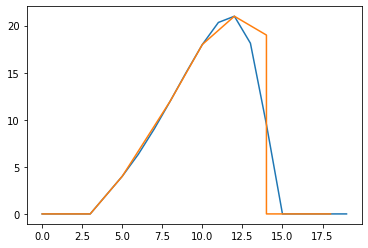

In [7]:
list_y = []
list_z = [axie_z for axie_z in range(20)]

for i in list_z:
    if polynomial_function(i) < 0:
        list_y.append(0)
    elif x_turbine_speed_axis[-1] < i:
        list_y.append(polynomial_function(x_turbine_speed_axis[-1]))
    else:
        list_y.append(polynomial_function(i))
        

plt.plot(list_z, list_y)
plt.plot(x_turbine_speed_axis, y_turbine_spower_axis)
plt.show()

In [8]:
#Count turbine power
my_data['power'] = 0
force_wind_power_for_turbine = x_turbine_speed_axis[-1]


for index, row in my_data.iterrows():
    if polynomial_function(row['wind']) < 0:
        my_data.at[index, 'power'] = 0
    elif force_wind_power_for_turbine < row['wind']:
        my_data.at[index, 'power'] = polynomial_function(force_wind_power_for_turbine)
    else:
        my_data.at[index, 'power'] = polynomial_function(row['wind'])

In [9]:
wind_power_data = pd.DataFrame()
wind_power_data = wind_power_data .assign(year=0, date=0, power=0)

current_analitic_time = datetime.strptime(time_from, '%Y-%m-%d').date()
time_to_datetime = datetime.strptime(time_to, '%Y-%m-%d').date()
day_hours = 24 

while time_to_datetime >= current_analitic_time:
    add_data_date = current_analitic_time.strftime("%m-%d")
    add_data_year = current_analitic_time.strftime("%Y")
    current_analitic_time_str = f'{current_analitic_time}'
    add_data_one_day = my_data[my_data['date'] == current_analitic_time_str]
    rows_number_in_current_day = len(add_data_one_day)
    add_data_power_sum = (add_data_one_day['power'].sum() * day_hours / rows_number_in_current_day).round(3)

    current_data = pd.DataFrame({"year": add_data_year,
                                 "date": add_data_date,
                                 "power": [add_data_power_sum]})
    wind_power_data = pd.concat([wind_power_data, current_data], ignore_index=True)
    
    current_analitic_time = current_analitic_time + timedelta(days=1)


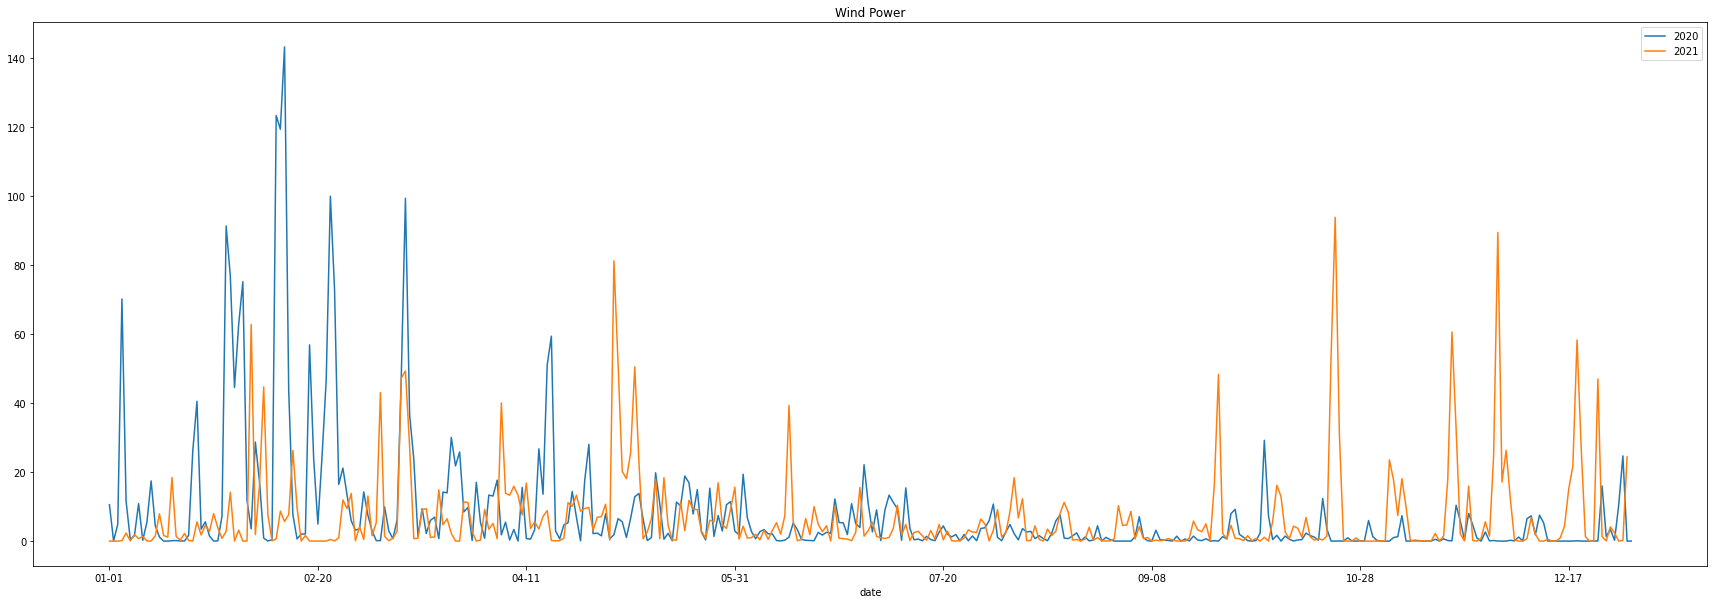

In [13]:
ax = plt.gca()

data_years_number = len(wind_power_data.year.unique())

for index in range(data_years_number):
    curret_year = wind_power_data.year.unique()[index]
    year_data = wind_power_data[wind_power_data['year'] == f'{curret_year}']
    year_data.plot(kind = 'line',
                x = 'date',
                y = 'power',
                ax = ax,
                label=f'{curret_year}'
                )
    
# set the title and size
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Wind Power')
  
# show the plot
plt.show()